In [ ]:
import pandas as pd
import numpy as np
import collections
import matplotlib.pyplot as plt

aas = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'H', 'I', 'G', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']

def sort_dict_by_key(mydict):
    sorted_dict = {}
    for key in sorted(mydict):
           sorted_dict[key] = mydict[key]
    return sorted_dict

# Load training data
training_data = pd.read_csv("training_data_cleaned.csv")
training_data = training_data.drop_duplicates()
training_data = training_data.dropna()
tm_helices = training_data.loc[training_data['Is Transmembrane'] == 1]
nontm_helices = training_data.loc[training_data['Is Transmembrane'] == -1]

print(tm_helices)

       Unnamed: 0 PDB ID Chain  Helix Start  Helix End  \
0               0   4X5M     C            2         18   
1               1   4X5M     C           19         30   
2               2   4X5M     C           36         58   
3               3   4X5M     C           59         87   
4               4   4X5M     C            2         19   
5               5   4X5M     C           19         30   
6               6   4X5M     C           36         58   
8               8   4X5M     C            3         19   
9               9   4X5M     C           19         30   
10             10   4X5M     C           36         58   
12             12   4CHW     D           12         29   
13             13   4CHW     D           34         62   
14             14   4CHW     D           71         92   
15             15   4CHW     D           94        105   
16             16   4CHW     D          106        112   
26             26   4CHW     D           12         29   
27            

There are 13434 Transmembrane Helices vs 45206 Non-TM Helices


<function matplotlib.pyplot.show(*args, **kw)>

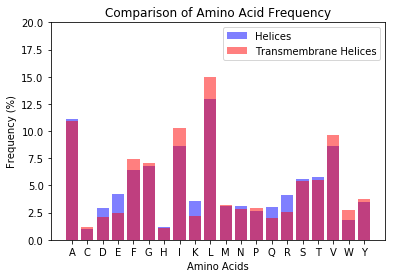

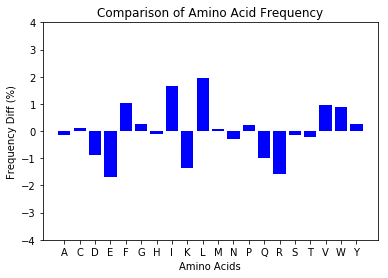

In [2]:
# Plots
tm_helix_sequences = list(tm_helices["Helix Sequence"])
tm_helix_aas = dict(collections.Counter("".join(tm_helix_sequences)))
tm_helix_aas_count = sum(tm_helix_aas.values())
for key in tm_helix_aas.keys():
    tm_helix_aas[key] = tm_helix_aas.get(key)/tm_helix_aas_count*100
tm_helix_aas = sort_dict_by_key(tm_helix_aas)


nontm_helix_sequences = list(nontm_helices["Helix Sequence"])
nontm_helix_aas = dict(collections.Counter("".join(nontm_helix_sequences)))
nontm_helix_aas_count = sum(nontm_helix_aas.values())
for key in nontm_helix_aas.keys():
    nontm_helix_aas[key] = nontm_helix_aas.get(key)/nontm_helix_aas_count*100
nontm_helix_aas = sort_dict_by_key(nontm_helix_aas)
    
print("There are", len(tm_helix_sequences),"Transmembrane Helices vs",len(nontm_helix_sequences), "Non-TM Helices")
f1 = plt.figure()
plt.bar(range(len(nontm_helix_aas)), list(nontm_helix_aas.values()), align='center', color='blue', alpha=0.5)
plt.bar(range(len(tm_helix_aas)), list(tm_helix_aas.values()), align='center', color='red', alpha=0.5)
plt.xticks(range(len(tm_helix_aas)), list(tm_helix_aas.keys()))
plt.title("Comparison of Amino Acid Frequency")
plt.legend(["Helices", "Transmembrane Helices"])
plt.xlabel("Amino Acids")
plt.ylabel("Frequency (%)")
plt.ylim([0,20])
plt.show 

diff_dict = {}
for key in tm_helix_aas:
    diff_dict[key] = tm_helix_aas[key]-nontm_helix_aas[key]
    
f2 = plt.figure()
plt.bar(range(len(nontm_helix_aas)), list(diff_dict.values()), align='center', color='blue')
plt.xticks(range(len(tm_helix_aas)), list(tm_helix_aas.keys()))
plt.title("Comparison of Amino Acid Frequency")
plt.xlabel("Amino Acids")
plt.ylabel("Frequency Diff (%)")
plt.ylim([-4,4])
plt.show 


In [3]:
# Create Features

def count_aas(helix):
    counts = []
    for aa in aas:
        counts.append(helix.count(aa))
    return counts

def create_aa_frequency_features(df):
    X = []
    Y = list(df["Is Transmembrane"])
    helices = list(df["Helix Sequence"])
    for helix in helices:
        X.append(count_aas(helix))  
    
    return X, Y
        
X, y = create_aa_frequency_features(training_data)

import pickle

with open('simple_aa_frequency_features.pkl', 'wb') as f:
    pickle.dump(np.array(X), f)

with open('simple_aa_frequency_labels.pkl', 'wb') as f:
    pickle.dump(np.array(y), f)

In [4]:
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from time import time
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn import preprocessing

X = preprocessing.scale(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
      
# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['roc_auc', 'f1']

file = "clf"+scores[0]
print(file)

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(), tuned_parameters, cv=5,
                       scoring=score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()
    
    with open('clf'+score+".pkl", 'wb') as f:
        pickle.dump(clf, f)

clfroc_auc
# Tuning hyper-parameters for roc_auc



KeyboardInterrupt: 